In [23]:
import os
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from module.sound import get_auduo_jump_power
import re

import importlib
#importlib.reload(module.sound)
# %load_ext autoreload
# %autoreload 2


Rename file in folder to format like 00011.wav

In [26]:
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_name = 'pushka'
file_number = 0
pattern = r'^(\d+)\.wav$'
# Rename file
for f in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, f)):
        folder_name = f
        file_number = 0
        path = os.path.join(folder_path, folder_name)
        for filename in os.listdir(path):
            match = re.search(pattern, filename)
                
            if match: 
                n = int(match.group(1))
                if n>file_number:
                    file_number = n
                # print(filename, file_number)
                #
                if filename!= f"{file_number:05}.wav":
                    if not os.path.isfile(os.path.join(path, f"{file_number:05}.wav")):
                        os.rename(os.path.join(path, filename), os.path.join(path,f"{file_number:05}.wav"));
        for filename in os.listdir(path):
            match = re.search(pattern, filename)
            n = int(match.group(1))
            new_file = f"{file_number:05}.wav"
            if not match or new_file!=filename:
                file_number = file_number + 1
                os.rename(os.path.join(path, filename), os.path.join(path,f"{file_number:05}.wav"))



In [13]:
def augmetion_audio_file_split(file_path, folder_lim_path, folder_name ,folder_lim_time, offset=1,  desired_sr=44100):
    # Создайте пустой DataFrame для хранения результатов

    folder  = os.path.join(folder_lim_path, folder_name)
    if not os.path.exists(folder):
        os.makedirs(folder)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    folder  = os.path.join(folder_path, folder_name)
    for filename in os.listdir(folder):
        if filename.endswith('.wav'): 
            file_path = os.path.join(folder_path, folder_name, filename)
            audio, sample_rate = librosa.load(file_path, sr=desired_sr)
            # Получение длины в секундах  
            audio_length = len(audio) / sample_rate
            folder_lim_time_sample = int(folder_lim_time*sample_rate)
            offset_sample = int(offset*folder_lim_time_sample)
            start_sample=0
            end_sample=folder_lim_time_sample
            sub_number =0
            while end_sample <= len(audio):
                sub_number = sub_number+1
                audio_split = audio[start_sample:end_sample]
                filename_new = filename[:-4] + f"_{sub_number:03}.wav"
                file_path_lim = os.path.join(folder_lim_path,folder_name, filename_new)
                sf.write(file_path_lim, audio_split, sample_rate, subtype='PCM_24')

                start_sample=start_sample+offset_sample
                end_sample=end_sample+offset_sample
                



def augmetion_audio_file_select(file_path, folder_lim_path, folder_name ,folder_lim_time, event_start=0.3, desired_sr=44100):
    
    # Specify the desired sampling rate (e.g., 44100 Hz)
    # desired_sr 

    # Создайте пустой DataFrame для хранения результатов
    file = []
    pick = []
    power = []

    # Путь к папке, содержащей ваши WAV-файлы
    data_csv = {'File':[], 'Pick':[], 'Power':[]}
    ##
    folder  = os.path.join(folder_lim_path, folder_name)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    folder  = os.path.join(folder_path, folder_name)
    for filename in os.listdir(folder):
        if filename.endswith('.wav'): 
            file_path = os.path.join(folder_path, folder_name, filename)
            audio, sample_rate = librosa.load(file_path, sr=desired_sr)
            # Получение длины в секундах  
            audio_length = len(audio) / sample_rate
            ( jump_x, jump_y  ) = get_auduo_jump_power(audio, sample_rate)
            if(len(jump_x)==0):
                print(filename, jump_x)
            else:
                data_csv['File'].append(filename)
                data_csv['Pick'].append(jump_x[0])
                data_csv ['Power'].append(jump_y[0])
                folder_lim_time_sample = int(folder_lim_time*sample_rate)
                if audio_length < 1:
                    padding = np.zeros(int(folder_lim_time_sample - len(audio)))
                    audio = np.concatenate(( padding, audio))
                else:
                    pik_time = jump_x[0]
                    pik_time_sample = int(pik_time*sample_rate)
                    start_time = pik_time_sample-int(folder_lim_time_sample*event_start)
                    pik_times=[start_time, start_time+folder_lim_time_sample]
                    if pik_times[0] < 0:
                        pik_times=[0, folder_lim_time_sample]
                    if pik_times[1] > len(audio):
                        pik_times=[len(audio-folder_lim_time_sample), len(audio)]

                    audio = audio[pik_times[0]:pik_times[1]]
                file_path_lim = os.path.join(folder_lim_path,folder_name, filename)
                sf.write(file_path_lim, audio, sample_rate, subtype='PCM_24')

    df = pd.DataFrame(data_csv) 

    # сохранение в Csv
    df.to_csv(os.path.join(folder_path, f'{folder_name}.xlsx'))


In [44]:
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_name = 'pushka'
folder_lim_time = 1
augmetion_audio_file_select(folder_path, folder_lim_path, folder_name, folder_lim_time)

In [16]:
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_lim_time = 1
augmetion_audio_file_split(folder_path, folder_lim_path, 'geran', folder_lim_time)
augmetion_audio_file_split(folder_path, folder_lim_path, 'none', folder_lim_time)
augmetion_audio_file_split(folder_path, folder_lim_path, 'roked', folder_lim_time)
augmetion_audio_file_split(folder_path, folder_lim_path, 'shots', folder_lim_time)


In [42]:

file_name = "00316.wav"
file_path = os.path.join(folder_path,folder_name, file_name)
ipd.Audio(file_path)
file_path = os.path.join(folder_lim_path,folder_name, file_name)
ipd.Audio(file_path)


In [70]:
audio, sample_rate = librosa.load(file_path, sr=desired_sr)


Text(0.5, 1.0, 'IMG_1880_2.wav')

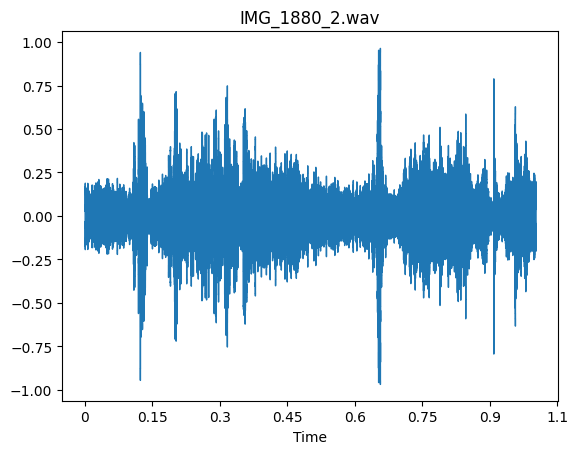

In [71]:

# Need show wave from audio array       

plt.subplots()
librosa.display.waveshow(audio, sr=sample_rate)
plt.title(file_name)


In [72]:
frameSize = 2048
hopSize = 512
stft_audio = librosa.stft(audio, n_fft = frameSize, hop_length = hopSize)
D_harmonic, D_percussive = librosa.decompose.hpss(stft_audio)

stft_audio_db = librosa.amplitude_to_db(np.abs(stft_audio), ref=np.max)
print(stft_audio.shape)

(1025, 87)


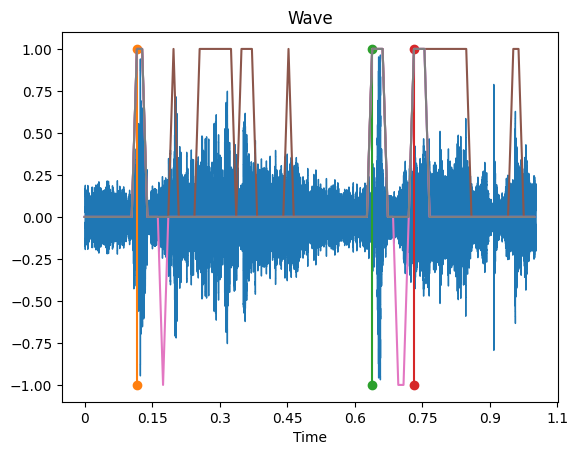

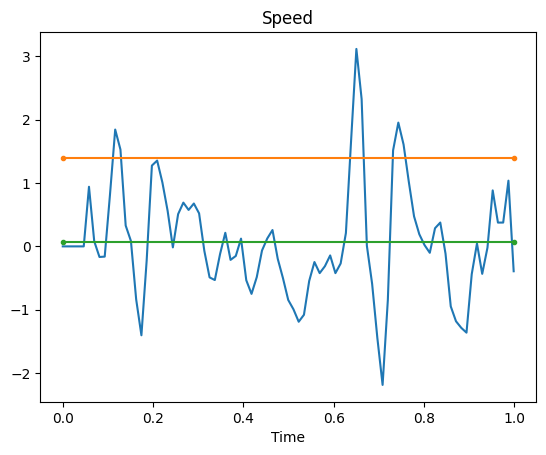

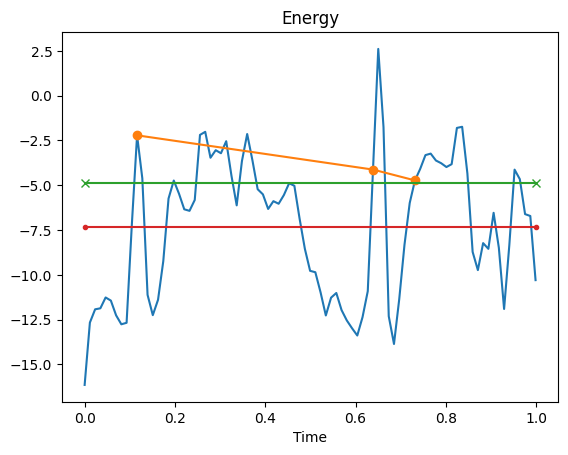

([0.11609977324263039, 0.6385487528344671, 0.7314285714285714],
 [-2.2139199, -4.125694, -4.729736])

In [75]:


get_auduo_jump_power(audio, sample_rate, show_chart=True)


(227.48734+28.657764j)


C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:12: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(stft_audio, ref=rp),sr=sample_rate, y_axis='log')
C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:17: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(D_harmonic, ref=rp), sr=sample_rate,y_axis='log')
C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:22: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(D_percussive, ref=rp),sr=sample_rate, y_axis='log', x_axis='time')


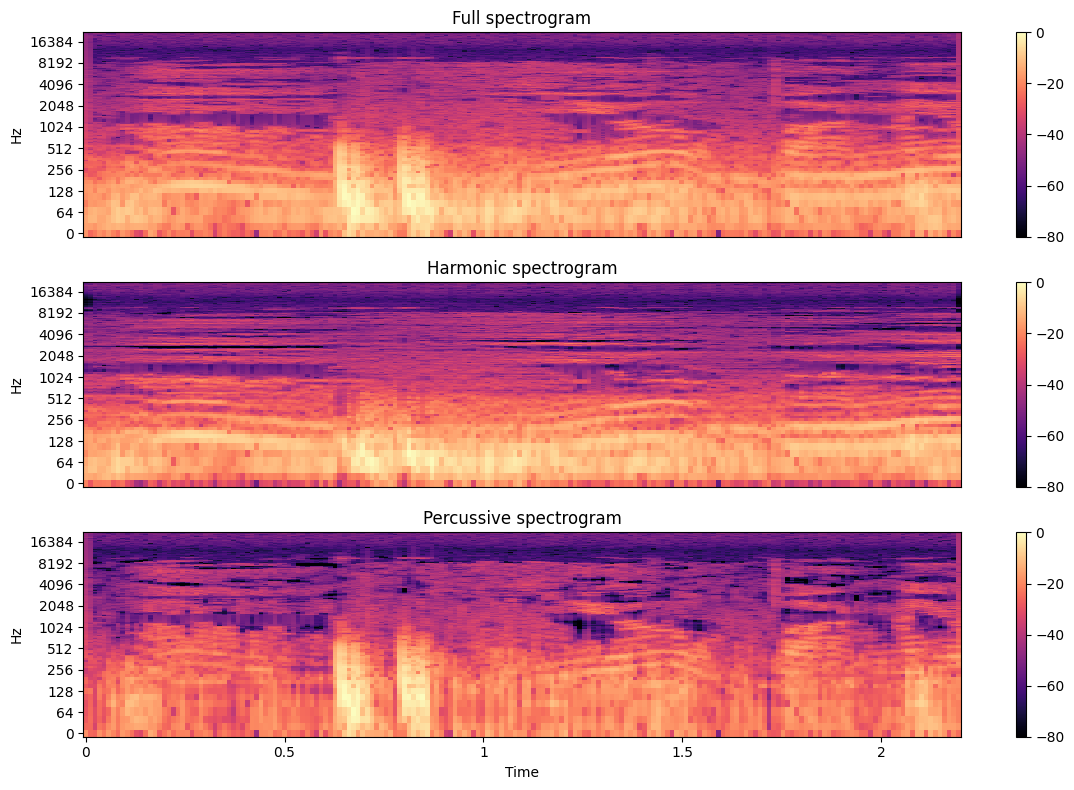

In [ ]:
stft_audio = librosa.stft(audio)#, n_fft = frameSize, hop_length = hopSize)
D_harmonic, D_percussive = librosa.decompose.hpss(stft_audio)

#rp = np.max(np.abs(stft_audio))
rp = np.max(stft_audio )
print(rp)
rp = np.max

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.power_to_db(stft_audio, ref=rp),sr=sample_rate, y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.power_to_db(D_harmonic, ref=rp), sr=sample_rate,y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.power_to_db(D_percussive, ref=rp),sr=sample_rate, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

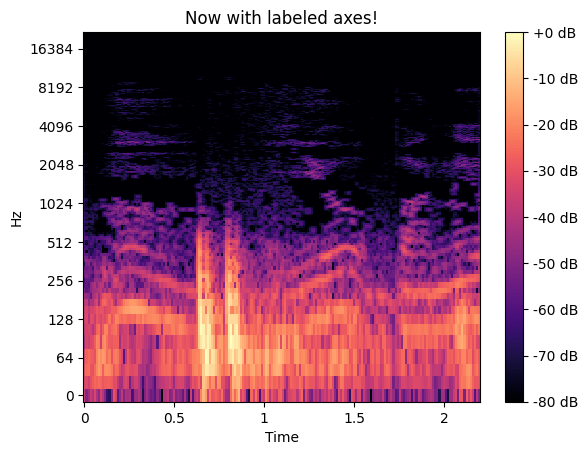

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(stft_audio_db,sr=sample_rate, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")


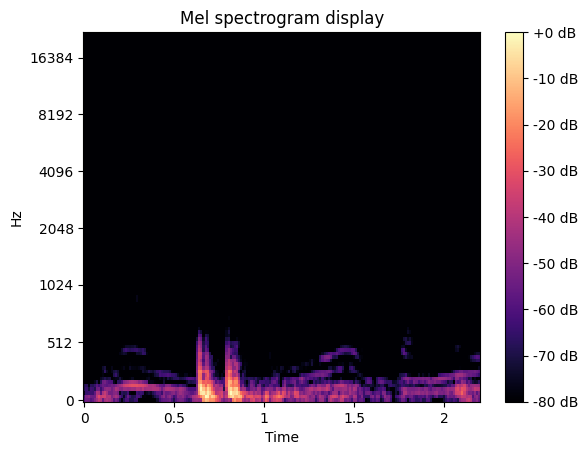

In [ ]:
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
M_db = librosa.power_to_db(M, ref=np.max)
M_db = librosa.amplitude_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel',sr=sample_rate, x_axis='time', ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")